In [1]:
%reload_ext autotime

import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
from scipy import interpolate
from scipy import stats
from datetime import datetime, timedelta
import pytz
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import geopandas as gpd
import tqdm.auto as tqdm
from glob import glob
import ee
from shapely.ops import split
from shapely import line_merge
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

/home/ubuntu/.local/lib/python3.10/site-packages/coastsat/SDS_download.py


In [2]:
service_account = 'service-account@iron-dynamics-294100.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, '.private-key.json')
ee.Initialize(credentials)

In [3]:
sitename = "nzd0188"
def read(f):
    vos = pd.read_csv(f)
    vos.drop(columns="Unnamed: 0", inplace=True)
    vos.set_index("dates", inplace=True)
    vos.index = pd.to_datetime(vos.index)
    return vos
vos = read(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
vos

,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
dates,,,,,,,,,,,,,,,
1999-08-12 21:52:44+00:00,196.828629,190.268379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.275274,160.324198,NaN,NaN,178.492409,171.223156
1999-08-19 21:58:52+00:00,207.485765,196.580927,195.307019,185.763909,179.419632,181.116426,177.300310,176.733878,169.656241,172.787792,180.749103,186.358245,183.475767,183.119576,NaN
1999-09-13 21:52:41+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.448816,NaN,NaN,185.438392,186.709556
1999-09-29 21:52:52+00:00,213.975717,203.984667,201.525830,202.736133,194.038465,189.686439,198.867256,193.963189,190.388081,193.107355,198.635200,208.950190,201.377834,199.960787,198.516028
1999-10-15 21:52:49+00:00,209.211102,199.819992,194.981584,191.413944,184.906999,186.674699,182.363095,180.816647,174.956075,175.884418,190.418498,206.180365,204.797575,196.827495,193.010532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-17 22:00:08+00:00,205.980687,201.920716,201.260355,192.136697,202.977916,187.639290,176.355046,179.283420,180.109304,184.509166,181.356575,183.129234,191.759309,191.176961,172.615341
2021-09-24 22:06:20+00:00,182.123699,182.349259,182.437096,180.023709,184.755441,164.179313,166.837185,167.775982,161.208635,160.153376,167.816446,170.377521,173.116707,170.685173,160.486284
2021-11-03 20:59:01+00:00,173.844782,170.171186,NaN,NaN,NaN,177.620110,151.458652,146.452454,157.949073,156.981268,158.699426,NaN,NaN,175.713936,163.554424


In [98]:
poly = gpd.read_file("polygons.geojson")
poly = poly[poly.id.str.startswith("nzd")]
poly.set_index("id", inplace=True)
poly

,area,id_sorted,northing,geometry
id,,,,
nzd0001,3.069093e+06,nzd0001,-4.085604e+06,"POLYGON ((172.96406 -34.43054, 172.99324 -34.4..."
nzd0002,1.507931e+06,nzd0002,-4.086100e+06,"POLYGON ((172.93456 -34.42857, 172.95856 -34.4..."
nzd0003,2.484730e+06,nzd0003,-4.087232e+06,"POLYGON ((173.0098 -34.42055, 173.00088 -34.44..."
nzd0006,9.619509e+05,nzd0004,-4.090732e+06,"POLYGON ((173.00532 -34.46694, 173.00612 -34.4..."
nzd0007,3.109433e+06,nzd0005,-4.095516e+06,"POLYGON ((172.99847 -34.48102, 173.00081 -34.5..."
...,...,...,...,...
nzd0317,9.986110e+05,nzd0556,-4.971830e+06,"POLYGON ((172.32302 -40.7187, 172.3121 -40.728..."
nzd0316,4.300058e+06,nzd0557,-4.966165e+06,"POLYGON ((172.37076 -40.70229, 172.39571 -40.6..."
nzd0313,2.291974e+07,nzd0558,-4.939929e+06,"POLYGON ((172.89281 -40.50518, 172.73306 -40.5..."


In [5]:
inputs = {
    "polygon": list(poly.geometry[sitename].exterior.coords),
    "dates": ['1900-01-01', '2030-12-30'], # All available imagery
    "sat_list": ['L5','L7','L8','L9'],
    "sitename": sitename,
    "filepath": 'data',
    "landsat_collection": 'C02',
}
#result = SDS_download.check_images_available(inputs)

In [6]:
#metadata = SDS_download.retrieve_images(inputs)
metadata = SDS_download.get_metadata(inputs)

In [7]:
shorelines = gpd.read_file("shorelines.geojson")
#shorelines = shorelines[shorelines.id.str.startswith("nzd")]
shorelines.set_index("id", inplace=True)
shorelines

,area,beach_length,easting,name,northing,Tide range,median_orientation,id_sorted,same_beach,median_slope,ci,n_points,n_points_nonan,geometry
id,,,,,,,,,,,,,,
aus0001,14472901.48412414,16824.52342226356,526589.1754011525,noname,7259734.061377056,1.451,92.466545,aus0001,None,0.076702,0.0214,654.0,520.0,"LINESTRING (153.26746 -24.70115, 153.26743 -24..."
aus0002,53438721.70867591,16794.63203331262,529484.7418874454,noname,7243833.021796449,1.073,64.603602,aus0002,1,0.059681,0.0203,579.0,407.0,"LINESTRING (153.26189 -24.85277, 153.26191 -24..."
aus0003,945965.0455573548,1373.06418305453,535380.0262458471,noname,7237842.578773651,1.074,93.116374,aus0003,None,0.041382,0.0112,335.0,243.0,"LINESTRING (153.35089 -24.96818, 153.35075 -24..."
aus0004,376936.0048626679,253.8720097247056,535397.4773649719,noname,7236435.680204276,1.074,79.203813,aus0004,None,0.051540,0.0154,319.0,238.0,"LINESTRING (153.35051 -24.98595, 153.35099 -24..."
aus0005,1570125.540326883,1830.166677525537,535675.2172291321,noname,7235101.123683789,1.074,74.946714,aus0005,None,0.054151,0.0245,307.0,231.5,"LINESTRING (153.35161 -24.99115, 153.35228 -24..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nzd0317,998611.0209522904,1388.636895098391,-4971829.852334809,noname,-4971829.852334809,NaN,309.396745,nzd0556,None,0.051980,0.0053,397.0,301.0,"LINESTRING (172.31541 -40.72839, 172.31783 -40..."
nzd0316,4300057.774234623,4647.035750366853,-4966165.280134064,noname,-4966165.280134064,NaN,304.531268,nzd0557,None,0.057371,0.0078,363.0,266.0,"LINESTRING (172.36751 -40.69864, 172.3702 -40...."
nzd0313,22919741.04033367,17378.17283613481,19237414.32246552,noname,-4939929.050573792,NaN,6.636156,nzd0558,None,0.026684,0.0057,324.0,125.0,"LINESTRING (172.73493 -40.50746, 172.73502 -40..."


In [51]:
# settings for the shoreline extraction
settings = {
    # general parameters:
    'cloud_thresh': 0.1,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 3857,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': False,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': True,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 40,      # threshold to identify cloud pixels in the s2cloudless probability mask
    # add the inputs defined previously
    'inputs': inputs
}

# [OPTIONAL] preprocess images (cloud masking, pansharpening/down-sampling)
#SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

In [76]:
transects = gpd.read_file("transects.geojson")
transects

,id,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
0,aus0001-0000,aus0001,104.347648,0.000000,0.000000,0.085,0.0545,0.2000,-1.892087,654.0,342.0,"LINESTRING (153.26555 -24.7007, 153.26938 -24...."
1,aus0001-0001,aus0001,93.495734,98.408334,0.002935,0.050,0.0387,0.0640,-1.205575,654.0,473.0,"LINESTRING (153.26525 -24.7019, 153.2692 -24.7..."
2,aus0001-0002,aus0001,82.069341,198.408334,0.005918,0.050,0.0428,0.0647,-0.698779,654.0,491.0,"LINESTRING (153.26539 -24.70316, 153.26931 -24..."
3,aus0001-0003,aus0001,81.192757,298.402523,0.008900,0.055,0.0480,0.0659,-0.303470,654.0,502.0,"LINESTRING (153.26555 -24.70408, 153.26945 -24..."
4,aus0001-0004,aus0001,81.065473,398.402523,0.011882,0.075,0.0614,0.0922,-0.105642,654.0,508.0,"LINESTRING (153.2657 -24.70497, 153.26961 -24...."
...,...,...,...,...,...,...,...,...,...,...,...,...
127402,nzd0561-0005,nzd0561,141.008990,499.608316,0.555889,0.085,0.0759,0.1026,0.204085,411.0,290.0,"LINESTRING (168.52498 -46.77668, 168.52724 -46..."
127403,nzd0561-0006,nzd0561,135.129214,599.517710,0.667053,0.090,0.0775,0.1055,0.196932,411.0,267.0,"LINESTRING (168.52416 -46.77717, 168.5267 -46...."
127404,nzd0561-0007,nzd0561,127.431653,698.799788,0.777520,0.080,0.0715,0.0931,0.358584,411.0,257.0,"LINESTRING (168.52342 -46.77775, 168.52627 -46..."
127405,nzd0561-0008,nzd0561,121.785300,798.799788,0.888785,0.070,0.0640,0.0812,0.196183,411.0,292.0,"LINESTRING (168.52282 -46.77836, 168.52587 -46..."


In [80]:
transects.to_crs(2193).length.describe()

count    127407.000000
mean        653.104157
std         368.109853
min         273.858707
25%         322.678094
50%         538.011446
75%         897.586515
max        1475.690493
dtype: float64

In [108]:
plt.ioff()

count    32357.000000
mean       -96.913352
std         16.042381
min       -126.141293
25%       -109.831806
50%        -97.275156
75%        -83.160770
max        -69.910778
Name: 2193_3857_diff, dtype: float64

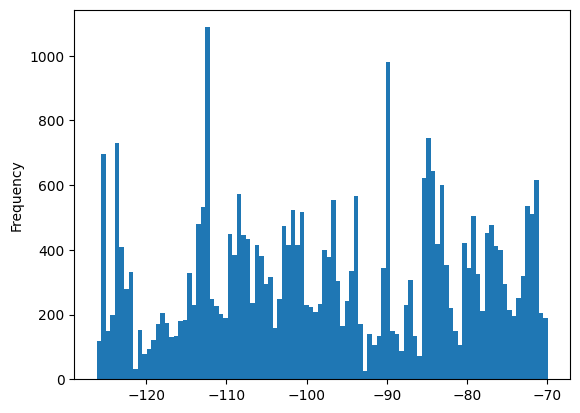

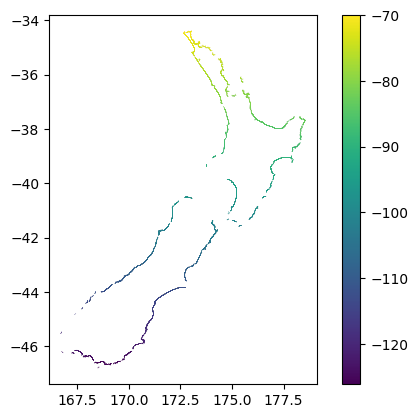

In [110]:
transects = gpd.read_file("transects.geojson")
transects = transects[transects.site_id.str.startswith("nzd")]
transects["2193_3857_diff"] = transects.to_crs(2193).length - transects.to_crs(3857).length
display(transects["2193_3857_diff"].describe())
transects["2193_3857_diff"].plot.hist(bins=100)
plt.show()
transects.plot("2193_3857_diff", legend=True)
plt.show()

In [95]:
import geopandas as gpd
from shapely.geometry import Point, LineString

line = gpd.GeoSeries([LineString([Point(-177.86957899263666, -29.231440487079798), Point(169.1272753839956, -52.61676648744082)])],crs=4326)
line.length, line.to_crs(2193).length

(0    347.783971
 dtype: float64,
 0    2.814568e+06
 dtype: float64)

In [81]:
transects.to_crs(3857).length.describe()

count    127407.000000
mean        436.886550
std          45.971594
min         391.408910
25%         400.000000
50%         417.590296
75%         458.385354
max         700.438399
dtype: float64

In [52]:
transects_gdf = gpd.read_file("transects.geojson")
transects_gdf.set_index("id", inplace=True)
transects_gdf = transects_gdf[transects_gdf.site_id == sitename]
display(transects_gdf)
transects = {}
for transect_id in transects_gdf.index:
    transects[transect_id] = np.array(transects_gdf.geometry.to_crs(settings["output_epsg"])[transect_id].coords)
transects

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
id,,,,,,,,,,,
nzd0188-0000,nzd0188,57.067769,0.000000,0.000000,0.085,0.0728,0.1053,-0.012672,538.0,378.0,"LINESTRING (175.85477 -36.98899, 175.85778 -36..."
nzd0188-0001,nzd0188,57.067769,100.000000,0.071452,0.130,0.1003,0.1945,0.013116,538.0,398.0,"LINESTRING (175.85525 -36.9896, 175.85827 -36...."
nzd0188-0002,nzd0188,57.028924,200.000000,0.142905,0.125,0.0984,0.1630,0.171418,538.0,397.0,"LINESTRING (175.85574 -36.9902, 175.85876 -36...."
nzd0188-0003,nzd0188,56.205388,299.998143,0.214356,0.095,0.0832,0.1136,0.250361,538.0,402.0,"LINESTRING (175.85625 -36.99082, 175.85923 -36..."
nzd0188-0004,nzd0188,55.420712,399.998143,0.285809,0.105,0.0915,0.1195,0.122757,538.0,413.0,"LINESTRING (175.85677 -36.99142, 175.85973 -36..."
nzd0188-0005,nzd0188,55.420712,499.998143,0.357261,0.100,0.0897,0.1136,0.180411,538.0,407.0,"LINESTRING (175.85728 -36.99202, 175.86024 -36..."
nzd0188-0006,nzd0188,54.557443,599.998143,0.428713,0.100,0.0876,0.1149,-0.051175,538.0,406.0,"LINESTRING (175.8578 -36.99262, 175.86073 -36...."
nzd0188-0007,nzd0188,52.909255,699.956883,0.500136,0.100,0.0896,0.1151,0.057596,538.0,403.0,"LINESTRING (175.85837 -36.99324, 175.86123 -36..."
nzd0188-0008,nzd0188,52.125016,799.956883,0.571589,0.100,0.0903,0.1147,-0.109327,538.0,397.0,"LINESTRING (175.85893 -36.99382, 175.86177 -36..."


{'nzd0188-0000': array([[19576062.90791524, -4437572.72117605],
        [19576398.63358546, -4437355.26250331]]),
 'nzd0188-0001': array([[19576117.27258343, -4437656.65259361],
        [19576452.99825365, -4437439.19392086]]),
 'nzd0188-0002': array([[19576171.71100508, -4437740.69779163],
        [19576507.28916836, -4437523.01155795]]),
 'nzd0188-0003': array([[19576227.77014321, -4437826.95423492],
        [19576560.18485618, -4437604.46724968]]),
 'nzd0188-0004': array([[19576286.06379616, -4437911.55413021],
        [19576615.40043215, -4437684.53567238]]),
 'nzd0188-0005': array([[19576342.81841062, -4437993.8882892 ],
        [19576672.15504661, -4437766.86983138]]),
 'nzd0188-0006': array([[19576401.30188256, -4438078.69051107],
        [19576727.18080357, -4437846.73592751]]),
 'nzd0188-0007': array([[19576463.89065728, -4438163.88223823],
        [19576782.96319821, -4437922.65057857]]),
 'nzd0188-0008': array([[19576526.95054562, -4438244.98975283],
        [19576842.691432

In [53]:
ref_sl = np.array(line_merge(split(shorelines.geometry.to_crs(settings["output_epsg"])[sitename], transects_gdf.to_crs(settings["output_epsg"]).unary_union)).coords)
ref_sl

array([[19576230.77075035, -4437463.99183968],
       [19576285.13541854, -4437547.92325724],
       [19576339.50008672, -4437631.85467479],
       [19576391.30012285, -4437711.82666039],
       [19576393.9774997 , -4437715.71074229],
       [19576450.73211415, -4437798.04490129],
       [19576507.48672861, -4437880.3790603 ],
       [19576564.24134306, -4437962.71321929],
       [19576591.25776228, -4438001.9060528 ],
       [19576623.42692774, -4438043.2664084 ],
       [19576684.82098909, -4438122.20163014],
       [19576746.21505044, -4438201.13685187],
       [19576748.97083   , -4438204.67999701],
       [19576799.70025601, -4438285.60550993],
       [19576852.81377498, -4438370.33421878],
       [19576867.25563079, -4438393.37241732],
       [19576914.43458038, -4438448.82837561],
       [19576979.23241498, -4438524.99425137],
       [19577027.78500329, -4438582.06483763],
       [19577046.60588836, -4438598.62721649],
       [19577098.19262281, -4438644.02354281]])

In [56]:
settings["max_dist_ref"] = 100
settings["reference_shoreline"] = ref_sl #np.flip(ref_sl)

In [57]:
output = SDS_shoreline.extract_shorelines(metadata, settings)

L5: Mapping Shorelines:   0%|          | 0/86 [00:00<?, ?it/s]

L7: Mapping Shorelines:   0%|          | 0/551 [00:00<?, ?it/s]

L7 2019-01-23-21-54-21: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


L8: Mapping Shorelines:   0%|          | 0/311 [00:00<?, ?it/s]

L8 2016-02-24-21-59-45: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2016-03-27-21-59-33: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2020-03-06-21-59-46: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2020-04-07-21-59-30: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2021-05-19-22-05-16: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2021-06-20-22-05-29: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2022-06-07-22-05-43: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2022-08-10-22-06-08: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L8 2022-09-27-22-06-16: Could not map shoreline due to error no valid pixels found in re

L9: Mapping Shorelines:   0%|          | 0/81 [00:00<?, ?it/s]

L9 2022-10-21-22-06-05: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2023-08-05-22-05-23: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2023-11-25-22-05-56: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2024-02-13-22-05-53: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.
L9 2024-03-16-22-05-47: Could not map shoreline due to error no valid pixels found in reference shoreline buffer.


In [23]:
# Have to flip to get x,y?
output['shorelines'] = [np.flip(s) for s in output['shorelines']]

In [58]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

8 duplicates
1 bad georef


In [59]:
from pyproj import CRS
geomtype = 'lines' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

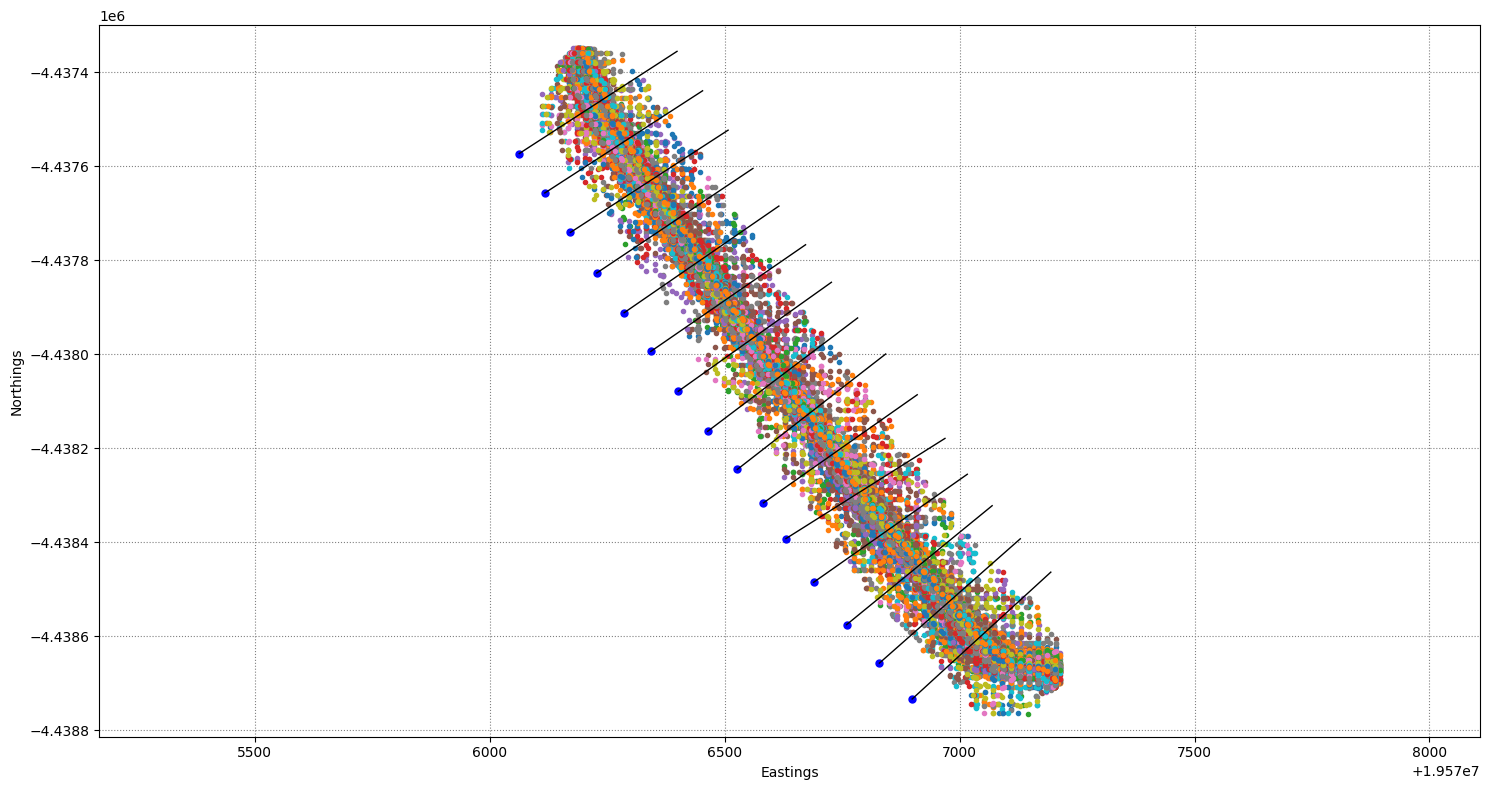

In [60]:
plt.ioff()
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'),lw=.1)
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    #plt.text(transects[key][0,0], transects[key][0,1], key.replace(f"{sitename}-0", ""),
    #            va='center', ha='center', bbox=dict(boxstyle="square", ec='k',fc='w'))
plt.show()

In [61]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

Computing transect shoreline intersections:   0%|          | 0/15 [00:00<?, ?it/s]

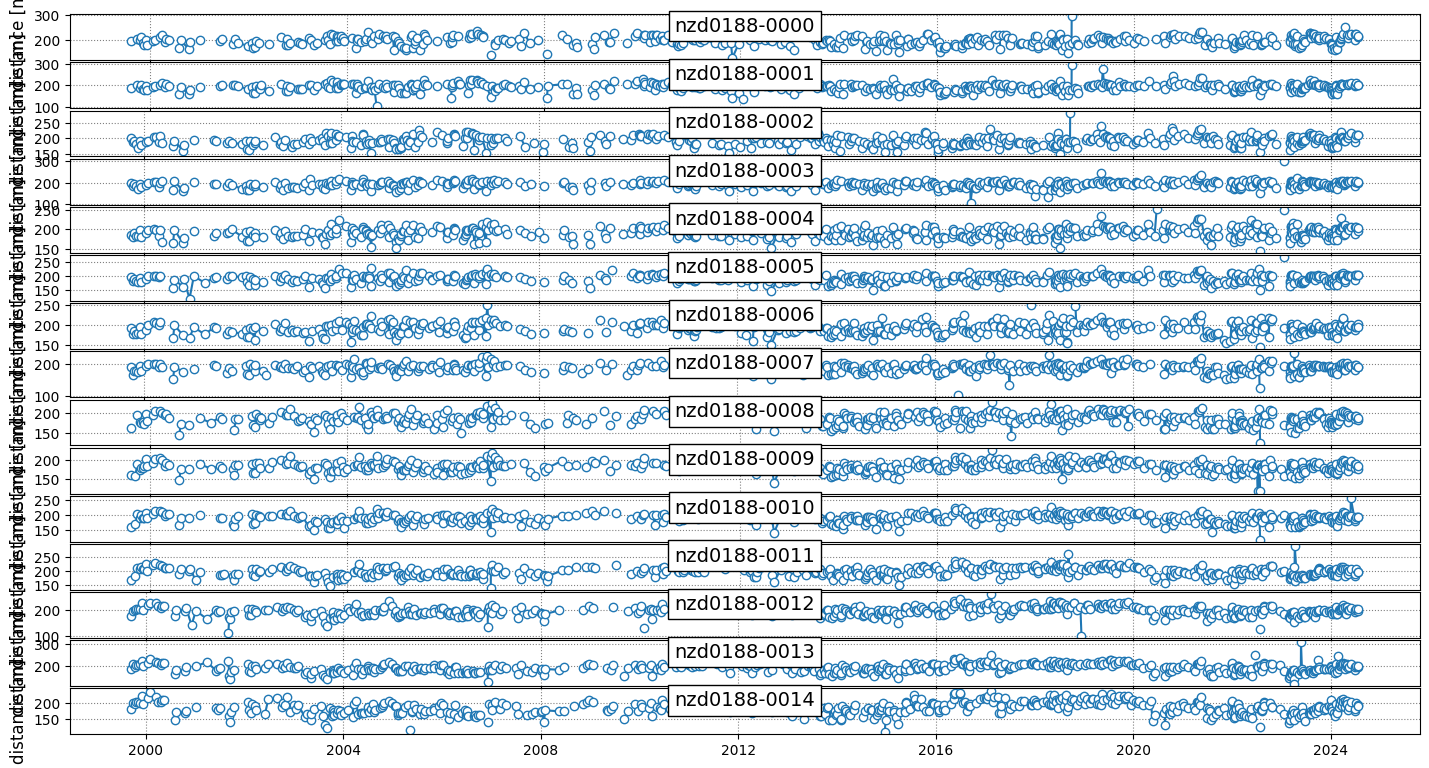

In [62]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)
plt.show()

In [63]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
out_dict["satname"] = output["satname"]
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
#df.to_csv(fn, sep=',')
#print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)
df

,dates,satname,nzd0188-0000,nzd0188-0001,nzd0188-0002,nzd0188-0003,nzd0188-0004,nzd0188-0005,nzd0188-0006,nzd0188-0007,nzd0188-0008,nzd0188-0009,nzd0188-0010,nzd0188-0011,nzd0188-0012,nzd0188-0013,nzd0188-0014
0,1999-08-12 21:52:44+00:00,L7,197.667069,187.990478,NaN,NaN,NaN,NaN,NaN,NaN,163.574540,158.578946,158.844323,165.707734,NaN,NaN,NaN
1,1999-09-13 21:52:41+00:00,L7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.379724,167.233893,181.111294,175.395874,188.064283,184.111264
2,1999-09-29 21:52:52+00:00,L7,203.173885,202.720695,201.385867,196.781391,185.372100,195.923789,192.544651,192.081898,194.478910,189.704683,201.973968,210.342807,197.122473,208.573178,200.153871
3,1999-10-15 21:52:49+00:00,L7,197.788374,189.314471,188.209240,183.945443,180.534297,182.946547,178.622918,167.535898,177.253609,173.217514,188.999137,205.581979,197.845789,194.240206,197.288034
4,1999-10-22 21:58:52+00:00,L7,210.477557,200.230692,191.440122,193.050492,190.606442,190.690768,184.107863,180.347128,176.265514,178.628726,197.507365,214.242323,203.239067,204.579721,203.516512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2024-06-28 22:05:19+00:00,L8,201.481200,197.578932,189.423430,185.090961,187.599105,184.964217,186.243573,182.674723,184.535809,179.545564,179.632671,181.983810,191.620867,184.704061,174.884558
708,2024-06-29 21:58:59+00:00,L9,221.951321,203.107087,199.618312,201.374015,205.030783,203.553244,195.080387,198.500781,191.830028,190.763732,186.602443,190.507724,199.398525,195.740568,183.559719
709,2024-07-07 21:59:13+00:00,L8,223.612215,211.459511,210.922320,205.868556,205.877132,203.237374,195.575431,197.371870,193.988624,189.305103,193.158319,205.837276,203.843064,201.853227,202.622249
710,2024-07-22 22:05:28+00:00,L9,212.403542,201.463180,209.525958,200.113808,195.143395,202.297678,201.422921,191.243169,182.432031,177.401289,191.146038,194.988798,196.638271,194.125873,194.390283


In [64]:
df.set_index("dates", inplace=True)
df.index = pd.to_datetime(df.index)

In [68]:
(df-vos).mean().mean()

3.16008048976669

In [69]:
df.shape, vos.shape

((712, 16), (538, 15))

In [70]:
transects_gdf.to_crs(settings["output_epsg"], inplace=True)
transects_gdf

,site_id,orientation,along_dist,along_dist_norm,beach_slope,cil,ciu,trend,n_points,n_points_nonan,geometry
id,,,,,,,,,,,
nzd0188-0000,nzd0188,57.067769,0.000000,0.000000,0.085,0.0728,0.1053,-0.012672,538.0,378.0,"LINESTRING (19576062.908 -4437572.721, 1957639..."
nzd0188-0001,nzd0188,57.067769,100.000000,0.071452,0.130,0.1003,0.1945,0.013116,538.0,398.0,"LINESTRING (19576117.273 -4437656.653, 1957645..."
nzd0188-0002,nzd0188,57.028924,200.000000,0.142905,0.125,0.0984,0.1630,0.171418,538.0,397.0,"LINESTRING (19576171.711 -4437740.698, 1957650..."
nzd0188-0003,nzd0188,56.205388,299.998143,0.214356,0.095,0.0832,0.1136,0.250361,538.0,402.0,"LINESTRING (19576227.77 -4437826.954, 19576560..."
nzd0188-0004,nzd0188,55.420712,399.998143,0.285809,0.105,0.0915,0.1195,0.122757,538.0,413.0,"LINESTRING (19576286.064 -4437911.554, 1957661..."
nzd0188-0005,nzd0188,55.420712,499.998143,0.357261,0.100,0.0897,0.1136,0.180411,538.0,407.0,"LINESTRING (19576342.818 -4437993.888, 1957667..."
nzd0188-0006,nzd0188,54.557443,599.998143,0.428713,0.100,0.0876,0.1149,-0.051175,538.0,406.0,"LINESTRING (19576401.302 -4438078.691, 1957672..."
nzd0188-0007,nzd0188,52.909255,699.956883,0.500136,0.100,0.0896,0.1151,0.057596,538.0,403.0,"LINESTRING (19576463.891 -4438163.882, 1957678..."
nzd0188-0008,nzd0188,52.125016,799.956883,0.571589,0.100,0.0903,0.1147,-0.109327,538.0,397.0,"LINESTRING (19576526.951 -4438244.99, 19576842..."


In [71]:
#df = pd.read_csv("data/nzd0188/transect_time_series.csv")
#df.drop(columns="Unnamed: 0", inplace=True)
#df.set_index("dates", inplace=True)
my_intersects = df.loc["2003-07-21 21:42:33+00:00"]
my_intersects

satname                 L5
nzd0188-0000     201.41361
nzd0188-0001    204.290092
nzd0188-0002    195.089171
nzd0188-0003     191.85769
nzd0188-0004    190.040593
nzd0188-0005    189.585028
nzd0188-0006    188.806124
nzd0188-0007     195.67555
nzd0188-0008    196.019977
nzd0188-0009     193.64007
nzd0188-0010    185.537321
nzd0188-0011    190.681022
nzd0188-0012    193.601484
nzd0188-0013    186.046824
nzd0188-0014      191.5192
Name: 2003-07-21 21:42:33+00:00, dtype: object

In [72]:
vos_intersects = vos.loc["2003-07-21 21:42:33+00:00"]
vos_intersects

nzd0188-0000    207.039370
nzd0188-0001    197.955344
nzd0188-0002    194.805314
nzd0188-0003    186.587322
nzd0188-0004    185.022602
nzd0188-0005    183.966109
nzd0188-0006    180.446069
nzd0188-0007    181.399493
nzd0188-0008    190.490556
nzd0188-0009    184.743819
nzd0188-0010    183.521960
nzd0188-0011    184.156911
nzd0188-0012    181.139068
nzd0188-0013    178.159517
nzd0188-0014    173.881791
Name: 2003-07-21 21:42:33+00:00, dtype: float64

In [73]:
(my_intersects - vos_intersects).mean()

6.699234170633337

In [74]:
from shapely import line_interpolate_point
my_intersect_points = gpd.GeoSeries(transects_gdf.index.to_series().apply(lambda transect_id: line_interpolate_point(transects_gdf.geometry[transect_id], my_intersects[transect_id])), crs=transects_gdf.crs)
vos_intersect_points = gpd.GeoSeries(vos_intersects.index.to_series().apply(lambda transect_id: line_interpolate_point(transects_gdf.geometry[transect_id], vos_intersects[transect_id])), crs=transects_gdf.crs)
my_intersect_points, vos_intersect_points

(id
 nzd0188-0000    POINT (19576231.957 -4437463.223)
 nzd0188-0001    POINT (19576288.736 -4437545.591)
 nzd0188-0002     POINT (19576335.38 -4437634.527)
 nzd0188-0003     POINT (19576387.211 -4437720.24)
 nzd0188-0004    POINT (19576442.532 -4437803.697)
 nzd0188-0005     POINT (19576498.912 -4437886.29)
 nzd0188-0006    POINT (19576555.122 -4437969.204)
 nzd0188-0007    POINT (19576619.977 -4438045.874)
 nzd0188-0008    POINT (19576681.679 -4438124.645)
 nzd0188-0009    POINT (19576741.012 -4438204.795)
 nzd0188-0010    POINT (19576787.464 -4438293.315)
 nzd0188-0011     POINT (19576845.19 -4438375.693)
 nzd0188-0012     POINT (19576909.48 -4438452.878)
 nzd0188-0013     POINT (19576968.77 -4438534.226)
 nzd0188-0014    POINT (19577040.349 -4438604.352)
 Name: id, dtype: geometry,
 nzd0188-0000    POINT (19576236.679 -4437460.165)
 nzd0188-0001    POINT (19576283.419 -4437549.035)
 nzd0188-0002    POINT (19576335.142 -4437634.682)
 nzd0188-0003    POINT (19576382.831 -4437723.171)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -inf, 'width': 88, 'height': 102, 'count': 5, 'crs': CRS.from_epsg(32660), 'transform': Affine(15.0, 0.0, 397905.0,
       0.0, -15.0, -4093875.0)}
(5, 102, 88)


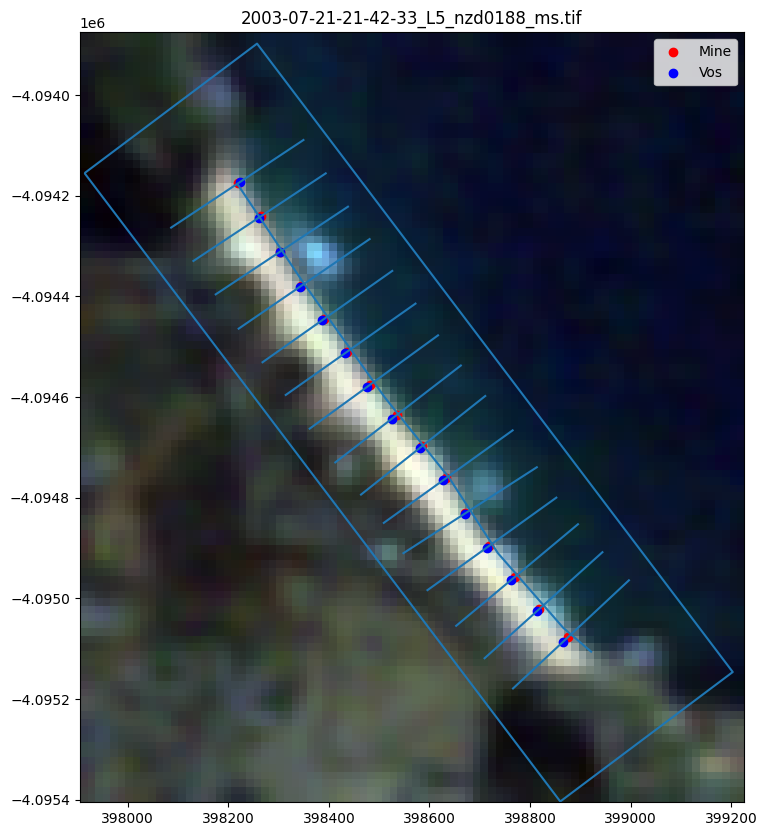

In [75]:
import rasterio as rio
from rasterio.plot import show
src = rio.open("data/nzd0188/L5/ms/2003-07-21-21-42-33_L5_nzd0188_ms.tif")
print(src.meta)
fig, ax = plt.subplots(figsize=(10,10))
# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
print(src.read().shape)
ax = show(src.read()[[2,1,0],:,:], extent=extent, ax=ax, adjust=True)
transects_gdf.to_crs(src.crs).plot(ax=ax)
gpd.GeoSeries([shorelines.geometry[sitename], poly.geometry[sitename].exterior], crs=shorelines.crs).to_crs(src.crs).plot(ax=ax)
my_intersect_points.to_crs(src.crs).plot(ax=ax, color="red", label="Mine")
vos_intersect_points.to_crs(src.crs).plot(ax=ax, color="blue", label="Vos")
plt.legend()
plt.title("2003-07-21-21-42-33_L5_nzd0188_ms.tif")
plt.show()

In [48]:
sitename = "nzd0202"
df = pd.read_csv(f"data/{sitename}/transect_time_series.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.set_index("dates", inplace=True)
df.index = pd.to_datetime(df.index)
vos = pd.read_csv(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
vos.drop(columns="Unnamed: 0", inplace=True)
vos.set_index("dates", inplace=True)
vos.index = pd.to_datetime(vos.index)

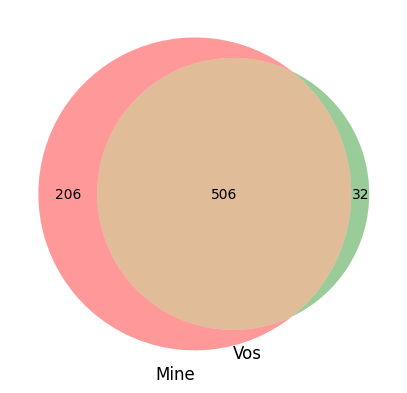

In [49]:
venn2([set(df.index), set(vos.index)], set_labels=('Mine', 'Vos'))
plt.show()

In [90]:
(df.drop(columns="satname") - vos).mean().describe()

count    15.000000
mean      3.160080
std       2.850384
min      -4.434607
25%       2.237699
50%       3.454840
75%       4.380313
max       8.106336
dtype: float64

In [21]:
df = pd.DataFrame({"filename": sorted(glob("data/*/transect_time_series.csv"))})
df["sitename"] = df.filename.str.split("/").str[1]
df

,filename,sitename
0,data/nzd0001/transect_time_series.csv,nzd0001
1,data/nzd0002/transect_time_series.csv,nzd0002
2,data/nzd0003/transect_time_series.csv,nzd0003
3,data/nzd0004/transect_time_series.csv,nzd0004
4,data/nzd0005/transect_time_series.csv,nzd0005
...,...,...
555,data/nzd0557/transect_time_series.csv,nzd0557
556,data/nzd0558/transect_time_series.csv,nzd0558
557,data/nzd0559/transect_time_series.csv,nzd0559
558,data/nzd0560/transect_time_series.csv,nzd0560


In [13]:
df["start"] = df.filename.apply(lambda f: pd.read_csv(f).dates.min())
df["end"] = df.filename.apply(lambda f: pd.read_csv(f).dates.max())
df

,filename,sitename,start,end
0,data/nzd0001/transect_time_series.csv,nzd0001,1999-08-17 22:10:26+00:00,2024-08-05 22:17:06+00:00
1,data/nzd0002/transect_time_series.csv,nzd0002,1999-10-04 22:10:38+00:00,2024-08-05 22:17:06+00:00
2,data/nzd0003/transect_time_series.csv,nzd0003,1999-08-17 22:10:26+00:00,2024-08-05 22:17:06+00:00
3,data/nzd0004/transect_time_series.csv,nzd0004,1999-10-04 22:10:38+00:00,2024-07-12 22:17:00+00:00
4,data/nzd0005/transect_time_series.csv,nzd0005,1999-08-17 22:10:26+00:00,2024-07-12 22:17:00+00:00
...,...,...,...,...
555,data/nzd0557/transect_time_series.csv,nzd0557,1999-08-17 22:13:37+00:00,2024-08-05 22:20:42+00:00
556,data/nzd0558/transect_time_series.csv,nzd0558,1999-10-04 22:13:49+00:00,2024-08-12 22:26:33+00:00
557,data/nzd0559/transect_time_series.csv,nzd0559,1999-07-16 22:13:35+00:00,2024-08-05 22:20:18+00:00
558,data/nzd0560/transect_time_series.csv,nzd0560,1999-08-17 22:13:37+00:00,2024-08-05 22:20:42+00:00


In [103]:
all_dates = []
for f in df.filename:
  all_dates.extend(pd.read_csv(f).dates)
len(all_dates)

227693

In [116]:
all_dates = pd.to_datetime(all_dates).to_series()
all_dates

1999-08-17 22:10:26+00:00   1999-08-17 22:10:26+00:00
1999-10-04 22:10:38+00:00   1999-10-04 22:10:38+00:00
2000-04-29 22:09:53+00:00   2000-04-29 22:09:53+00:00
2000-06-16 22:09:26+00:00   2000-06-16 22:09:26+00:00
2000-08-03 22:08:44+00:00   2000-08-03 22:08:44+00:00
                                       ...           
2024-04-14 22:26:30+00:00   2024-04-14 22:26:30+00:00
2024-04-30 22:26:19+00:00   2024-04-30 22:26:19+00:00
2024-05-16 22:26:05+00:00   2024-05-16 22:26:05+00:00
2024-06-17 22:26:08+00:00   2024-06-17 22:26:08+00:00
2024-07-12 22:20:36+00:00   2024-07-12 22:20:36+00:00
Length: 227693, dtype: datetime64[ns, UTC]

<Axes: title={'center': 'Landsat acquisition by year'}>

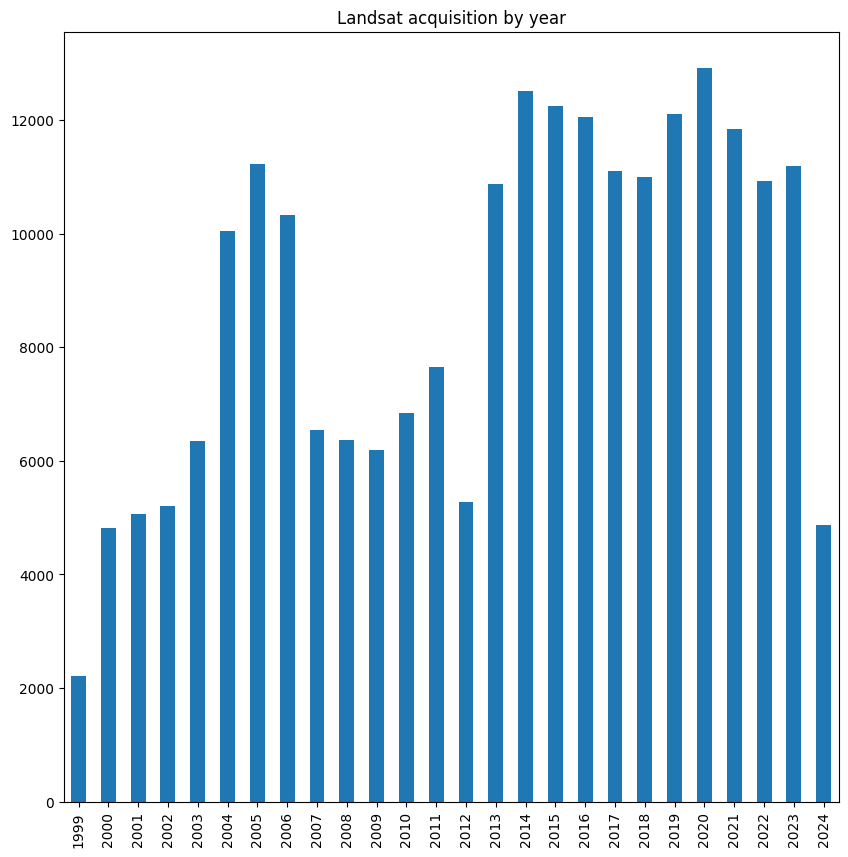

In [123]:
all_dates.groupby(all_dates.dt.year).count().plot.bar(figsize=(10,10), title="Landsat acquisition by year")

<Axes: xlabel='end'>

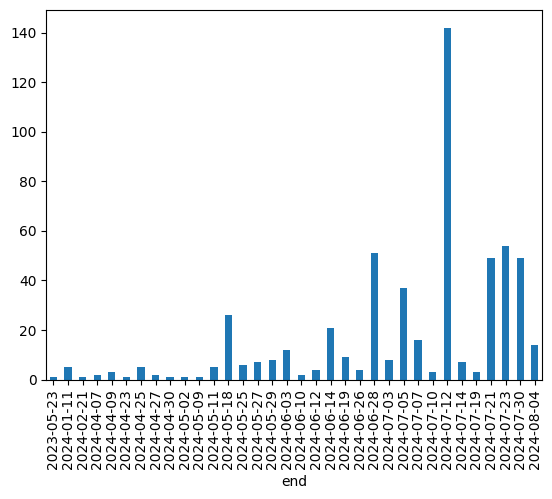

In [98]:
df.end = pd.to_datetime(df.end)
df.groupby(df.end.dt.date).end.count().plot(kind="bar")

In [22]:
def get_vos_diff(sitename):
    df = pd.read_csv(f"data/{sitename}/transect_time_series.csv")
    df.drop(columns="Unnamed: 0", inplace=True)
    df.set_index("dates", inplace=True)
    df.index = pd.to_datetime(df.index)
    vos = pd.read_csv(f"shoreline_data_run6/New_Zealand/{sitename}/time_series_raw.csv")
    vos.drop(columns="Unnamed: 0", inplace=True)
    vos.set_index("dates", inplace=True)
    vos.index = pd.to_datetime(vos.index)
    return (df - vos).mean(axis=1)

diff_result = df.sitename.apply(get_vos_diff)

<Axes: ylabel='Frequency'>

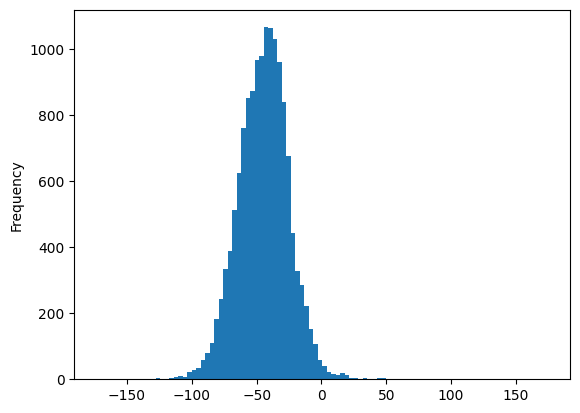

In [23]:
diff_result.mean().plot.hist(bins=100)

In [30]:
diff_result.mean().describe()

count    32004.000000
mean       -44.427875
std         21.820595
min       -357.977268
25%        -59.491487
50%        -42.821800
75%        -30.240118
max        181.798978
dtype: float64